In [1]:
import pymysql
import pandas as pd
from orion import Orion

In [7]:
def load_data(crop):
    '''Load data from smartfarm DB use pymysql library'''
    
    crops_list = ['strawberry', 'tomato', 'paprica']
    crop = crop.lower()
    if crop not in crops_list:
        raise Exception(f'{crop} is not valid crop. \n Please input one of ["strawberry", "tomato", "paprica"]')
        
    query= ''
    if crop=='strawberry':
        query =  '''
            SELECT xdatetime, xinsunadd, xintemp1, xsthum, xco2, xco2set, region, area FROM MIRYANG_SENSING_DATA 
            WHERE (region="mysb6" AND area="6" ) OR
            (region="mysb6" AND area="1") OR
            (region="mysb4" AND area="4") OR
            (region="mysb6" AND area="5")
            '''
    elif crop=='tomato':
        query =  '''
            SELECT xdatetime, xinsunadd, xintemp1, xsthum, xco2, xco2set, region, area FROM MIRYANG_SENSING_DATA 
            WHERE (region="mysb4" AND area="1" ) OR
            (region="mysb4" AND area="2") OR
            (region="mysb4" AND area="3") OR
            (region="mysb2" AND area="2") OR
            (region="mysb6" AND area="2")
            '''
    else:
        query = '''
            SELECT xdatetime, xinsunadd, xintemp1, xsthum, xco2, xco2set, region, area FROM MIRYANG_SENSING_DATA 
            WHERE (region="mysb2" AND area="1" )
            '''

    conn = pymysql.connect(host='127.0.0.1', user='root', db='smartfarm', charset='utf8')

    cur = conn.cursor()

    data = pd.read_sql_query(query, conn)
    data = data.sort_values(by='xdatetime')
    data = data.reset_index(drop=True)
    data['zone'] = data['region'] + '_' + data['area']
    data = data.drop(['region', 'area'], axis=1)
    return data

In [32]:
strawberry = load_data('strawberry')

In [33]:
zone_6_5 = strawberry[strawberry['zone']=='mysb6_5']

In [34]:
def make_train_df(df, column):
    train_df = df[['xdatetime', column]].rename(columns={'xdatetime': 'timestamp', column: 'value'})

    # 저장일시 column 을 모델 input 양식(timestamp)으로 변경
    train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
    train_df['timestamp'] = train_df['timestamp'].apply(lambda x : x.timestamp())

    # input type : integer or float
    train_df['timestamp'] = train_df['timestamp'].astype('int')
    return train_df

In [35]:
import time

def get_model(df, crop, column):
    start_time = time.time()

    df = make_train_df(df, column)
    hyperparameters = {
        'mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate#1': { 
            'interval': 3600 # 집계할 시간 초단위 / 60분 단위 집계이므로 3600입력
        },
        'orion.primitives.tadgan.TadGAN#1': {
            'epochs': 5,
            'verbose': True
        }
    }
    orion = Orion(
        pipeline='tadgan',
        hyperparameters=hyperparameters
    )
    orion.fit(df)
    print('time_taken \t', time.time() - start_time)

    orion.save(f'./detect_model/{crop}_{column}.json')
    return df, orion

In [36]:
insun, model_insun = get_model(zone_6_5, 'strawberry', 'xinsunadd')

Epoch: 1/5, Losses: {'cx_loss': 0.4401, 'cz_loss': 7.0031, 'eg_loss': -3.3174}
Epoch: 2/5, Losses: {'cx_loss': -0.7186, 'cz_loss': -30.2983, 'eg_loss': 32.5994}
Epoch: 3/5, Losses: {'cx_loss': -0.8252, 'cz_loss': -0.1573, 'eg_loss': -2.6753}
Epoch: 4/5, Losses: {'cx_loss': -0.5465, 'cz_loss': 2.2108, 'eg_loss': -5.1457}
Epoch: 5/5, Losses: {'cx_loss': -0.4525, 'cz_loss': 2.3342, 'eg_loss': -6.2091}
time_taken 	 304.374653339386


# ====paprica====

In [46]:
paprica = load_data('paprica')

In [50]:
zone_2_1 = paprica[paprica['zone']=='mysb2_1']

In [56]:
insun, model_insun_p = get_model(zone_2_1, 'paprica', 'xinsunadd')

Epoch: 1/5, Losses: {'cx_loss': -1.2711, 'cz_loss': 4.793, 'eg_loss': -2.2443}
Epoch: 2/5, Losses: {'cx_loss': -5.9185, 'cz_loss': -15.9884, 'eg_loss': 22.0344}
Epoch: 3/5, Losses: {'cx_loss': -11.6512, 'cz_loss': -1.2805, 'eg_loss': -33.9399}
Epoch: 4/5, Losses: {'cx_loss': -13.6862, 'cz_loss': 1.9517, 'eg_loss': -71.2371}
Epoch: 5/5, Losses: {'cx_loss': -4.1847, 'cz_loss': 2.5963, 'eg_loss': -78.3475}
time_taken 	 224.02667689323425


In [37]:
thum['datetime']=pd.to_datetime(thum['timestamp'], unit='s')
thum.set_index('datetime', inplace=True, drop=True)

thum_anomalies['start'] = pd.to_datetime(thum_anomalies['start'], unit='s')
thum_anomalies['end'] = pd.to_datetime(thum_anomalies['end'], unit='s')

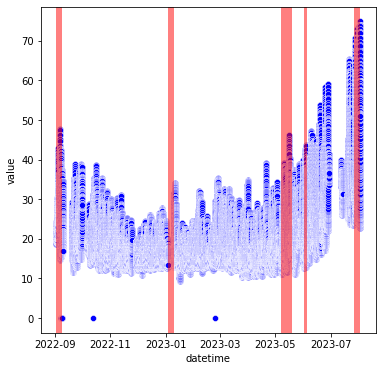

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x='datetime', y='value', data=thum, color='blue')

for idx in thum_anomalies.index:
    plt.axvspan(thum_anomalies.loc[idx, 'start'], thum_anomalies.loc[idx, 'end'], facecolor='red', alpha=0.5)
    
plt.show()